In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
test_df = pd.read_csv('SRER_2017_training_bi.csv', na_values='?').dropna()
train_df = pd.read_csv('JORN17_dataset_v2.csv', na_values='?').dropna()
train_df.head()
test_df.head()

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_max,ARVI_mean,ARVI_med,EVI_max,EVI_mean,EVI_med,NDVI_max,NDVI_mean,NDVI_med,SAVI_max,SAVI_mean,SAVI_med,Veg_class
0,1,2,2,41.6,17.41,0.190714,0.609099,0.344183,0.379428,0.443455,0.292047,0.290985,0.665698,0.476709,0.507514,0.406991,0.286203,0.288351,woody
1,2,3,3,31.4,5.05,0.045000,0.387755,0.245301,0.274936,0.332059,0.252919,0.244477,0.526375,0.406745,0.433791,0.328585,0.254814,0.248126,non-woody
2,3,5,5,33.4,4.84,0.010000,0.038844,0.004040,0.026805,0.150550,0.131985,0.134891,0.208300,0.181575,0.205117,0.150184,0.131642,0.135063,non-woody
3,4,6,6,32.2,14.20,0.011667,0.189842,0.033418,0.018961,0.198972,0.141579,0.138338,0.341480,0.207390,0.197327,0.197330,0.141500,0.138725,non-woody
4,5,7,7,28.8,10.73,0.013750,0.322694,0.080315,0.061453,0.248442,0.158710,0.142326,0.457103,0.247391,0.228112,0.248598,0.158618,0.142817,non-woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

    testindex8.append(test_index)
    testindex9.append(pred_values)
    
elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.03494869999999972 seconds ---

Accuracy of each fold: 
 [0.6962264150943396, 0.7, 0.7320754716981132, 0.7169811320754716, 0.722117202268431]
Avg accuracy: 0.7134800442272711
Std of accuracy : 
0.013505904994468661

[[ 521  456]
 [ 303 1369]]

              precision    recall  f1-score   support

   non-woody       0.63      0.53      0.58       977
       woody       0.75      0.82      0.78      1672

    accuracy                           0.71      2649
   macro avg       0.69      0.68      0.68      2649
weighted avg       0.71      0.71      0.71      2649

0.5332650972364381
0.81877990430622
0.6322815533980582
0.5785674625208218


In [7]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)
woodyarea4 = 0
nonwoodyarea4 = 0
totalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,5):
            for l in testindex9[k]:
                if l == "woody":
                    woodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC4 = woodyarea4/totalarea4 * 100
                    
print(FWC4)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex8:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded = woodyarea1/totalarea1 * 100\nprint(needed)\nwoodyarea4 = 0\nnonwoodyarea4 = 0\ntotalarea4 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex8:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex9[k]:\n                if l == "woody":\n                    woodyarea4 += test_df.iat[j,4]\n                    totalarea4 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea4 += test_df.iat[j,4]\n                    totalarea4 += test_df.iat[j,4]\nelapsed = time

In [8]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 0.16018829999999973 seconds ---

Accuracy of each fold: 
 [0.7320754716981132, 0.7566037735849057, 0.779245283018868, 0.7679245283018868, 0.77882797731569]
Avg accuracy: 0.7629354067838927
Std of accuracy : 
0.017526564791166103

[[ 628  349]
 [ 279 1393]]

              precision    recall  f1-score   support

   non-woody       0.69      0.64      0.67       977
       woody       0.80      0.83      0.82      1672

    accuracy                           0.76      2649
   macro avg       0.75      0.74      0.74      2649
weighted avg       0.76      0.76      0.76      2649

0.6427840327533265
0.8331339712918661
0.6923925027563396
0.6666666666666666


In [9]:
"""woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,5):
            for l in testindex2[k]:
                if l == "woody":
                    woodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC = woodyarea1/totalarea1 * 100
                    
print(FWC)"""


'woodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex1:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nprint(woodyarea1/totalarea1 * 100)\n\nneeded2 = woodyarea1/totalarea1 * 100\nprint(needed2)\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\nstart_time = timeit.default_timer()\n\nfor i in testindex1:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex2[k]:\n                if l == "woody":\n                    woodyarea1 += test_df.iat[j,4]\n                    totalarea1 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea1 += test_df.iat[j,4]\n                    totalarea1

In [10]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    #makes the list for FWC
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 0.2615626999999998 seconds ---

Accuracy of each fold: 
 [0.6981132075471698, 0.7226415094339622, 0.6547169811320754, 0.6547169811320754, 0.6805293005671077]
Avg accuracy: 0.6821435959624782
Std of accuracy : 
0.026085067918039904

[[861 116]
 [726 946]]

              precision    recall  f1-score   support

   non-woody       0.54      0.88      0.67       977
       woody       0.89      0.57      0.69      1672

    accuracy                           0.68      2649
   macro avg       0.72      0.72      0.68      2649
weighted avg       0.76      0.68      0.68      2649

0.8812691914022518
0.5657894736842105
0.5425330812854442
0.671606864274571


In [11]:

"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)
woodyarea2 = 0
nonwoodyarea2 = 0
totalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,5):
            for l in testindex4[k]:
                if l == "woody":
                    woodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC2 = woodyarea2/totalarea2 * 100
                    
print(FWC2)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex3:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded3 = woodyarea1/totalarea1 * 100\nprint(needed3)\nwoodyarea2 = 0\nnonwoodyarea2 = 0\ntotalarea2 = 0\nstart_time = timeit.default_timer()\n\nfor i in testindex3:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex4[k]:\n                if l == "woody":\n                    woodyarea2 += test_df.iat[j,4]\n                    totalarea2 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea2 += test_df.iat[j,4]\n                    totalarea2 += test_df.iat[j,4]\nelapsed = time

#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [12]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.72641509 0.70943396 0.72641509 0.73773585 0.72022684]

Avg accuracy: 0.7240453686200377

K=2

Accuracy of each fold: 
 [0.68867925 0.69811321 0.70754717 0.68679245 0.6899811 ]

Avg accuracy: 0.6942226343760032

K=3

Accuracy of each fold: 
 [0.72075472 0.73773585 0.76981132 0.73396226 0.74858223]

Avg accuracy: 0.742169276313443

K=4

Accuracy of each fold: 
 [0.70754717 0.75471698 0.74339623 0.70188679 0.73913043]

Avg accuracy: 0.7293355209187858

K=5

Accuracy of each fold: 
 [0.73396226 0.75471698 0.77735849 0.72830189 0.75803403]

Avg accuracy: 0.7504747298213076

K=6

Accuracy of each fold: 
 [0.72830189 0.76037736 0.77924528 0.7245283  0.731569  ]

Avg accuracy: 0.744804365659664

K=7

Accuracy of each fold: 
 [0.73773585 0.75471698 0.77735849 0.72830189 0.76181474]

Avg accuracy: 0.7519855904697363

K=8

Accuracy of each fold: 
 [0.73396226 0.75471698 0.76981132 0.72264151 0.7637051 ]

Avg accuracy: 0.7489674358882905

K=9

Accuracy of each fold

In [13]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)


elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 1.8053312999999998 seconds ---

Accuracy of each fold: 
 [0.7433962264150943, 0.7528301886792453, 0.7830188679245284, 0.730188679245283, 0.776937618147448]
Avg accuracy: 0.7572743160823198
Std of accuracy : 
0.019977040630257493

[[ 614  363]
 [ 280 1392]]

              precision    recall  f1-score   support

   non-woody       0.69      0.63      0.66       977
       woody       0.79      0.83      0.81      1672

    accuracy                           0.76      2649
   macro avg       0.74      0.73      0.73      2649
weighted avg       0.75      0.76      0.75      2649

0.6284544524053224
0.8325358851674641
0.6868008948545862
0.6563335114911812


In [14]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)
woodyarea3 = 0
nonwoodyarea3 = 0
totalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,5):
            for l in testindex6[k]:
                if l == "woody":
                    woodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC3 = woodyarea3/totalarea3 * 100
                    
print(FWC3)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex5:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded4 = woodyarea1/totalarea1 * 100\nprint(needed4)\nwoodyarea3 = 0\nnonwoodyarea3 = 0\ntotalarea3 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex5:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex6[k]:\n                if l == "woody":\n                    woodyarea3 += test_df.iat[j,4]\n                    totalarea3 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea3 += test_df.iat[j,4]\n                    totalarea3 += test_df.iat[j,4]\n\nelapsed = 

In [15]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.713480,0.013506,0.533265,0.818780,0.632282,0.578567,0.034949
LDA,0.762935,0.017527,0.642784,0.833134,0.692393,0.666667,0.160188
QDA,0.682144,0.026085,0.881269,0.565789,0.542533,0.671607,0.261563
KNN-CV,0.757274,0.019977,0.628454,0.832536,0.686801,0.656334,1.805331


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.7134800442272711, 0.7629354067838927, 0.6821435959624782, 0.7572743160823198]
Sen[0.5332650972364381, 0.6427840327533265, 0.8812691914022518, 0.6284544524053224]
Spec[0.81877990430622, 0.8331339712918661, 0.5657894736842105, 0.8325358851674641]
P[0.6322815533980582, 0.6923925027563396, 0.5425330812854442, 0.6868008948545862]
F1[0.5785674625208218, 0.6666666666666666, 0.671606864274571, 0.6563335114911812]


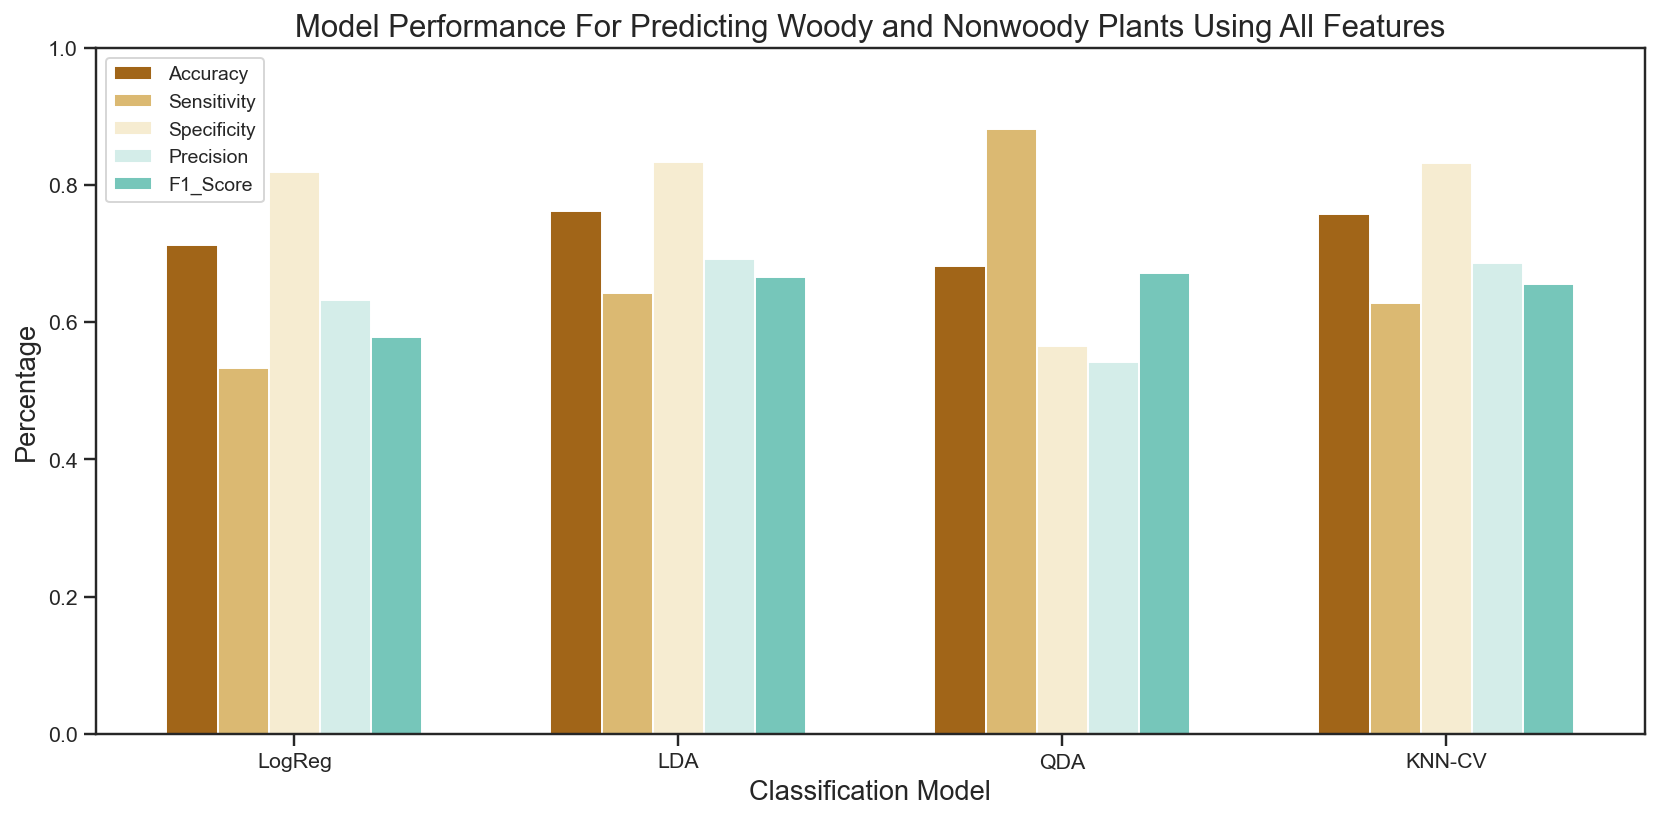

In [16]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

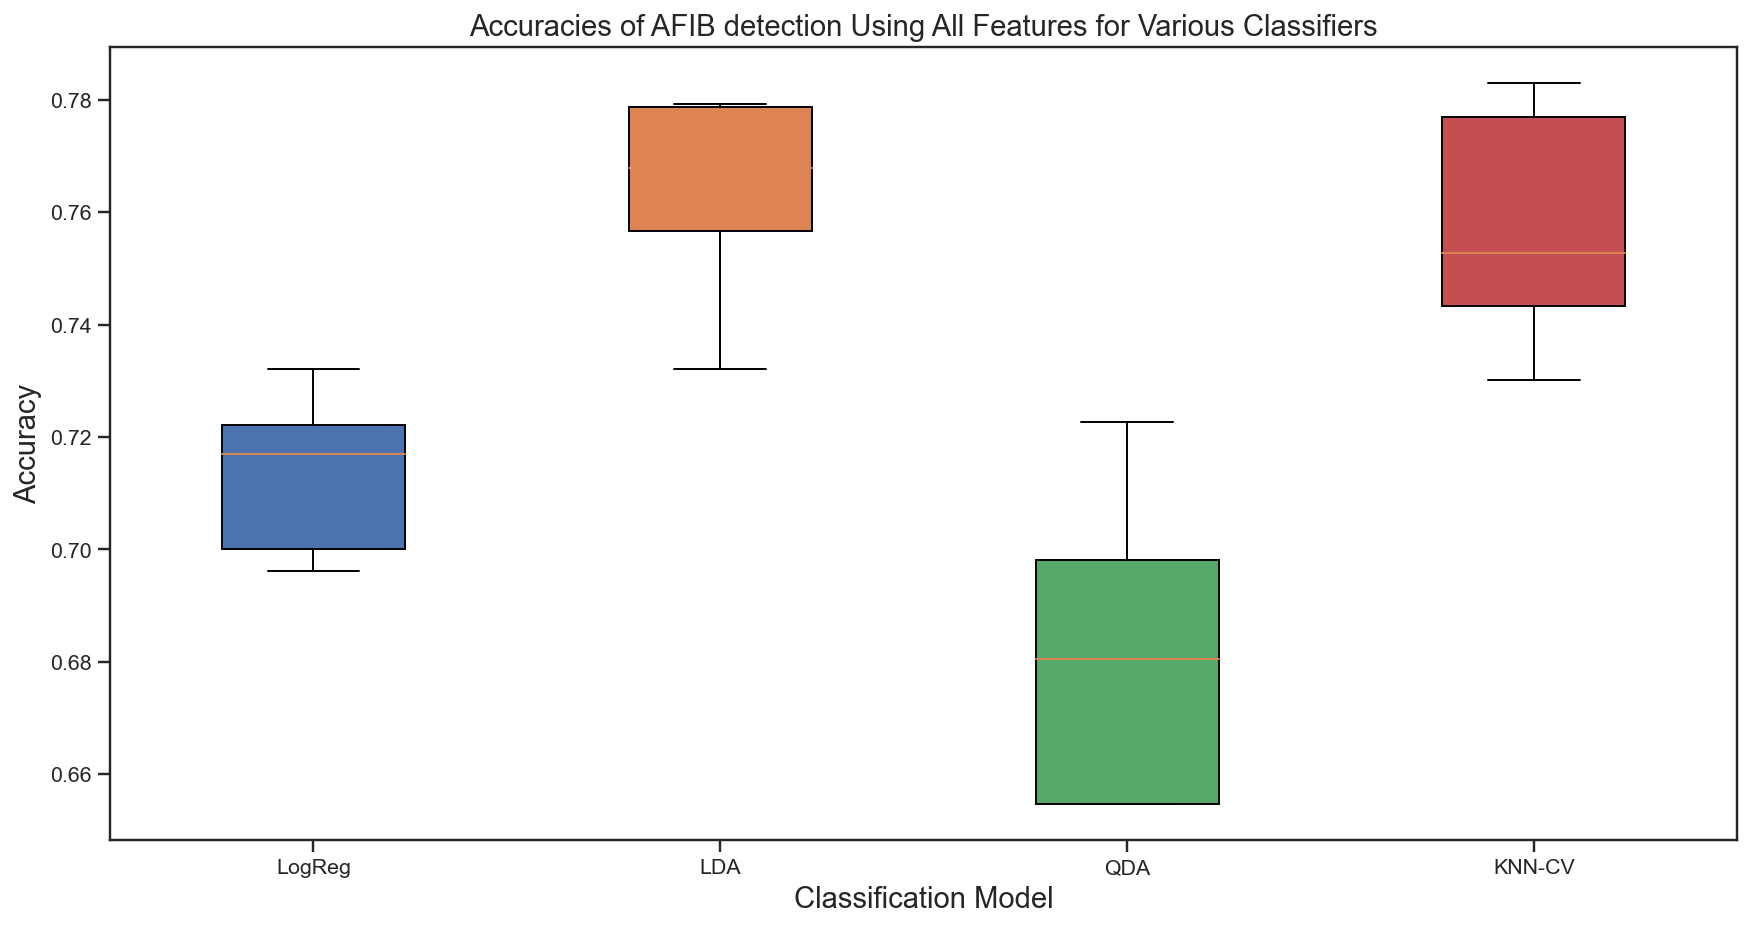

In [17]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [18]:
"""
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(FWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(FWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(FWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(FWC3))
"""

'\nprint("Log reg act: " + str(needed))\nprint("Log reg pred: " + str(FWC4))\nprint("QDA act: " + str(needed2))\nprint("QDA pred: " + str(FWC2))\nprint("LDA act: " + str(needed3))\nprint("LDA pred: " + str(FWC))\nprint("KNN act: " + str(needed4))\nprint("KNN pred: " +str(FWC3))\n'